In [1]:
# Standard library imports
import os
import pickle
import random
from collections import defaultdict, deque
from pathlib import Path

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Local application imports
import tkinter as tk
from tkinter import messagebox

In [2]:
def train_model(data_path: str = './data', epochs: int = 100):
    # Define the paths
    train_dir = f'{data_path}/train'
    valid_dir = f'{data_path}/valid'
    test_dir = f'{data_path}/test'
    
    # Load the CSV file
    dataset_csv = pd.read_csv(f'{data_path}/cards.csv')

    # Create ImageDataGenerator for loading and augmenting images
    train_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    model_path = f'./models/{epochs}_model.h5'
    if Path(model_path).exists():
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.load_weights(model_path)  # Load your trained model weights
        return model
    else:
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=valid_generator
        )
    
        # Evaluate the model
        loss, accuracy = model.evaluate(test_generator)
        print(f'Test accuracy: {accuracy}')
    
        model.save(model_path)

    return model

In [3]:
model = train_model(epochs=5)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [4]:
class CardCounter:
    high_cards = ('ten', 'jack', 'queen', 'king', 'ace')
    low_cards = ('two', 'three', 'four', 'five', 'six')

    def __init__(self, model, n_decks: int = 8):
        self.model = model
        self.n_decks = n_decks
        self.total_cards = 52 * n_decks
        self._count = 0
        self._remaining_cards = {
            'total': self.total_cards, 
            'high': int(round(self.total_cards * 5 / 13)), 
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }
        
        self.test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            './data/test',
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
        )
        
        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}

    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, count: int):
        self._count = count

    @property
    def remaining_cards(self):
        return self._remaining_cards

    @remaining_cards.setter
    def remaining_cards(self, remaining_cards: int):
        self._remaining_cards = remaining_cards

    def reset_deck(self):
        self.total_cards = 52 * self.n_decks
        
        self.remaining_cards = {
            'total': self.total_cards, 
            'high': int(round(self.total_cards * 5 / 13)), 
            'low': int(round(self.total_cards * 5 / 13)),
            'neutral': int(round(self.total_cards * 3 / 13))
        }
        
        self.count = 0
        self.card_counts = {label: 0 for label in self.test_generator.class_indices.keys()}
    
    def classify_card(self, image):
        image = tf.image.resize(image, (224, 224))
        image = tf.expand_dims(image, 0)  # Add batch dimension
        predictions = self.model.predict(image)
        class_index = tf.argmax(predictions[0]).numpy()
        class_label = list(self.test_generator.class_indices.keys())[class_index]
        return class_label
    
    def count_cards(self, images):
        high_cards = 0
        low_cards = 0
        neutral_cards = 0
        card_labels = []
        for image in images:
            card_label = self.classify_card(image=image)
            rank = card_label.split()[0]
            suit = card_label.split()[-1]
            card_labels.append((rank, suit))
            self.card_counts[card_label] += 1
            
            if card_label.split()[0] in self.high_cards:
                self.count -= 1
                high_cards += 1
            elif card_label.split()[0] in self.low_cards:
                self.count += 1
                low_cards += 1
            else:
                neutral_cards += 1
    
        # Calculate remaining cards
        self.remaining_cards['total'] -= len(images)
        self.remaining_cards['high'] -= high_cards
        self.remaining_cards['low'] -= low_cards
        self.remaining_cards['neutral'] -= neutral_cards
    
        prob_high = self.remaining_cards['high'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_low = self.remaining_cards['low'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0
        prob_neutral = self.remaining_cards['neutral'] / self.remaining_cards['total'] if self.remaining_cards['total'] > 0 else 0

        return prob_high, prob_low, prob_neutral, card_labels

In [5]:
image_paths = [r'.\data\test\ace of clubs\1.jpg', r'.\data\test\nine of clubs\1.jpg', 
               r'.\data\test\six of clubs\1.jpg', r'.\data\test\king of hearts\1.jpg']

images = [tf.io.read_file(image_path) for image_path in image_paths]
images = [tf.image.decode_jpeg(image, channels=3) for image in images]

In [6]:
card_counter = CardCounter(model=model)
prob_high, prob_low, prob_neutral, card_labels = card_counter.count_cards(images=images)
print(f'Predicted Cards: {card_labels}')
print(f'Probability of next card being +1 count: {prob_low:.2f}')
print(f'Probability of next card being -1 count: {prob_high:.2f}')
print(f'Probability of next card being 0 count: {prob_neutral:.2f}')

Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 104ms/step
Predicted Cards: [('ten', 'clubs'), ('eight', 'clubs'), ('jack', 'spades'), ('queen', 'hearts')]
Probability of next card being +1 count: 0.39
Probability of next card being -1 count: 0.38
Probability of next card being 0 count: 0.23


In [30]:
class BlackjackGame:
    def __init__(self, root, bankroll: int, model_path: str):
        self.root = root
        self.root.title("Blackjack Game")

        self.suits = ('hearts', 'diamonds', 'clubs', 'spades')
        self.ranks = {
            'two': 2, 
            'three': 3, 
            'four': 4, 
            'five': 5, 
            'six': 6, 
            'seven': 7, 
            'eight': 8, 
            'nine': 9, 
            'ten': 10, 
            'jack': 10, 
            'queen': 10, 
            'king': 10, 
            'ace': 11
        }
        
        self.model_path = model_path

        # Load the trained model
        self.model = self.load_model()

        # Initialize game variables
        self.card_counter = CardCounter(model=self.model)
        self.deck = self.create_deck()
        self.player_hands = []
        self.dealer_hand = []
        self.card_images = []
        self.wins = 0
        self.losses = 0
        self.draws = 0
        self.bankroll = bankroll
        self.active_hand = 0  # Track active hand index (0 for player hand, 1+ for split hands)

        # Create GUI elements
        self.create_widgets()

    def load_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        model.load_weights(self.model_path)  # Load your trained model weights
        return model

    def create_deck(self):
        deck = [(rank, suit) for rank in self.ranks.keys() for suit in self.suits for _ in range(self.card_counter.n_decks)]
        # random.shuffle(deck)
        return deck

    def create_widgets(self):
        self.player_label = tk.Label(self.root, text="Player's Hand")
        self.player_label.pack()
        
        self.frames_container = tk.Frame(self.root)
        self.frames_container.pack()

        self.player_frame = [tk.Frame(self.frames_container, padx=25) for i in range(4 * self.card_counter.n_decks) if i != 0 else tk.Frame(self.frames_container, padx=25, bg='lightblue']
        self.player_frame.pack(side=tk.LEFT)
        
        self.dealer_label = tk.Label(self.root, text="Dealer's Hand")
        self.dealer_label.pack()
        self.dealer_frame = tk.Frame(self.root)
        self.dealer_frame.pack()
    
        self.hit_button = tk.Button(self.root, text="Hit", command=self.hit)
        self.hit_button.pack(side=tk.LEFT)
        self.stand_button = tk.Button(self.root, text="Stand", command=self.stand)
        self.stand_button.pack(side=tk.LEFT)
        self.split_button = tk.Button(self.root, text="Split", command=self.split)  # Add split button
        self.split_button.pack(side=tk.LEFT)
        self.reset_button = tk.Button(self.root, text="Reset", command=self.reset_game)
        self.reset_button.pack(side=tk.LEFT)
    
        self.prob_label = tk.Label(self.root, text="Probabilities - High: 0.00, Low: 0.00, Neutral: 0.00")
        self.prob_label.pack()
    
        self.game_label = tk.Label(self.root, text="Game 1: Wins - 0, Losses - 0, Draws - 0 -- Cards Left = 416")
        self.game_label.pack()
    
        self.wallet_label = tk.Label(self.root, text=f"Bankroll: ${self.bankroll}")
        self.wallet_label.pack()

    def start_game(self):
        self.deal_card_to_player()
        self.deal_card_to_dealer()
        self.deal_card_to_player()
        self.deal_card_to_dealer()
        
        player_value = self.calculate_hand_value(self.player_hand)
        dealer_value = self.calculate_hand_value(self.dealer_hand)
        if player_value == 21:
            self.wins += 1
            self.update_game_label(150)
            messagebox.showinfo("Blackjack", "Blackjack! Player Wins!")
            self.reset_hand()
        elif dealer_value == 21:
            self.losses += 1
            self.update_game_label(-100)
            messagebox.showinfo("Blackjack", "Dealer wins!")
            self.reset_hand()
            
        # Enable the split button if the player has two cards of the same rank
        self.update_split_button_state()

    def update_split_button_state(self):
        can_split = any(len(hand) == 2 and hand[0][0] == hand[1][0] for hand in [self.player_hand] + self.split_hands)
        self.split_button.config(state=tk.NORMAL if can_split else tk.DISABLED)

    def split(self):
        # Check if the active hand can be split
        active_hand = self.player_hands[self.active_hand]
        if len(active_hand) == 2 and active_hand[0][0] == active_hand[1][0]:
            new_hand = [self.player_hands[self.active_hand].pop()]
            
        
        if self.active_hand == 0:
            if len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
                self.split_hands.append([self.player_hand.pop()])
                self.deal_card_to_player()
                self.deal_card_to_split_hand(self.split_hands[-1])
        elif self.active_hand <= len(self.split_hands[self.active_hand - 1]):
            if len(self.split_hands[self.active_hand - 1]) == 2 and self.split_hands[self.active_hand - 1][0][0] == self.split_hands[self.active_hand - 1][1][0]:
                self.split_hands.append([self.split_hands[self.active_hand - 1].pop()])
                self.deal_card_to_split_hand(self.split_hands[-1])
                self.deal_card_to_split_hand(self.split_hands[self.active_hand - 1])
                
        self.update_split_button_state()
        for split_frame in self.split_frames[:len(self.split_hands)]:
            split_frame.pack(side=tk.LEFT, padx=10)
    
        self.update_hand_display()

    def deal_card_to_split_hand(self, hand):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            
        hand.append(card)
        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return
        
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)
            frame = tk.Frame(self.split_frames[len(self.split_hands) - 1])
            frame.pack(side=tk.LEFT)
            label = tk.Label(frame, image=photo)
            label.image = photo
            label.pack()
            tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

        self.update_probabilities_label(prob_high, prob_low, prob_neutral)
        
    def update_probabilities_label(self, prob_high, prob_low, prob_neutral):
        self.prob_label.config(text=f'Probabilities - High: {prob_high:.2f}, Low: {prob_low:.2f}, Neutral: {prob_neutral:.2f}')
    
    def update_game_label(self, rewards: int):
        self.game_label.config(text=f'Game {self.wins + self.losses + self.draws}: Wins - {self.wins}, Losses - {self.losses}, Draws - {self.draws} -- Cards Left = {self.card_counter.remaining_cards["total"]}')
        self.bankroll += rewards
        self.wallet_label.config(text=f"Bankroll: ${self.bankroll}")

    def highlight_active_hand(self):
        # Reset all frames' background color
        self.player_frame.config(bg='lightblue' if self.active_hand == 0 else 'SystemButtonFace')
        for i, frame in enumerate(self.split_frames):
            if i < len(self.split_hands):
                frame.config(bg='lightblue' if self.active_hand == i + 1 else 'SystemButtonFace')
    
    def update_hand_display(self):
        for widget in self.player_frame.winfo_children():
            widget.destroy()
        for split_frame in self.split_frames:
            for widget in split_frame.winfo_children():
                widget.destroy()
            
        for card in self.player_hand:
            img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path)
                    img = img.resize((100, 150), Image.LANCZOS)
                    photo = ImageTk.PhotoImage(img)
                    self.card_images.append(photo)
                    frame = tk.Frame(self.player_frame)
                    frame.pack(side=tk.LEFT)
                    label = tk.Label(frame, image=photo)
                    label.image = photo
                    label.pack()
                    tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
                except Exception as e:
                    print(f"Failed to load image {img_path}: {e}")
                    
        for i, hand in enumerate(self.split_hands):
            for card in hand:
                img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
                if os.path.exists(img_path):
                    try:
                        img = Image.open(img_path)
                        img = img.resize((100, 150), Image.LANCZOS)
                        photo = ImageTk.PhotoImage(img)
                        self.card_images.append(photo)
                        frame = tk.Frame(self.split_frames[i])
                        frame.pack(side=tk.LEFT)
                        label = tk.Label(frame, image=photo)
                        label.image = photo
                        label.pack()
                        tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
                    except Exception as e:
                        print(f"Failed to load image {img_path}: {e}")

        self.highlight_active_hand()
    
    def deal_card_to_player(self):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            
        self.player_hand.append(card)
        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return
        
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)
            frame = tk.Frame(self.player_frame)
            frame.pack(side=tk.LEFT)
            label = tk.Label(frame, image=photo)
            label.image = photo
            label.pack()
            tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

        self.update_probabilities_label(prob_high, prob_low, prob_neutral)
    
    def deal_card_to_dealer(self):
        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.deck = self.create_deck()
            self.card_counter.reset_deck()
            
        self.dealer_hand.append(card)
        img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
        
        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            return
        
        images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
        prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)

        try:
            img = Image.open(img_path)
            img = img.resize((100, 150), Image.LANCZOS)
            photo = ImageTk.PhotoImage(img)
            self.card_images.append(photo)
            frame = tk.Frame(self.dealer_frame)
            frame.pack(side=tk.LEFT)
            label = tk.Label(frame, image=photo)
            label.image = photo
            label.pack()
            tk.Label(frame, text=f'{card[0]} of {card[1]}').pack()
        except Exception as e:
            print(f"Failed to load image {img_path}: {e}")

        self.update_probabilities_label(prob_high, prob_low, prob_neutral)

    def hit(self):
        if self.active_hand == 0:
            # Player's main hand
            self.deal_card_to_player()
            player_value = self.calculate_hand_value(self.player_hand)
            if player_value >= 21:
                self.active_hand += 1
                self.highlight_active_hand()
        else:
            # One of the split hands
            self.deal_card_to_split_hand(self.split_hands[self.active_hand - 1])
            hand_value = self.calculate_hand_value(self.split_hands[self.active_hand - 1])
            if hand_value >= 21:
                self.active_hand += 1
                self.highlight_active_hand()
                if self.active_hand > len(self.split_hands):
                    self.stand()
            else:
                self.highlight_active_hand()

    def stand(self):
        if self.active_hand <= len(self.split_hands):
            self.active_hand += 1
            self.highlight_active_hand()
            if self.active_hand <= len(self.split_hands):
                return
    
        # If no more hands to play, process the dealer's turn
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.deal_card_to_dealer()
    
        dealer_value = self.calculate_hand_value(self.dealer_hand)
        player_value = self.calculate_hand_value(self.player_hand)
        split_values = [self.calculate_hand_value(hand) for hand in self.split_hands]
    
        # Compare dealer's hand with player's hands
        message = self.compare_hands(player_value, dealer_value, "Player")
        for idx, split_value in enumerate(split_values):
            message += self.compare_hands(split_value, dealer_value, f"Split {idx + 1}")
    
        messagebox.showinfo("Blackjack", message)
        self.reset_hand()
    
    def compare_hands(self, player_value, dealer_value, hand_name):
        player_blackjack_win = player_value == 21
        player_regular_win = (player_value < 21 and (dealer_value > 21 or player_value > dealer_value))
        draw = player_value < 21 and player_value == dealer_value
        dealer_wins = dealer_value <= 21 and player_value < dealer_value
    
        message = ""
        if player_blackjack_win:
            self.wins += 1
            self.update_game_label(150)
            message += f"{hand_name} Blackjack! Player wins!\n"
        elif player_regular_win:
            self.wins += 1
            self.update_game_label(100)
            message += f"{hand_name} Value: {player_value} > Dealer Value: {dealer_value}\n"
        elif draw:
            self.draws += 1
            message += f"{hand_name} Value: {player_value} == Dealer Value: {dealer_value}\n"
        elif dealer_wins:
            self.losses += 1
            self.update_game_label(-100)
            message += f"Dealer Value: {dealer_value} > {hand_name} Value: {player_value}\n"
    
        return message
            
    def reset_hand(self):
        for widget in self.player_frame.winfo_children():
            widget.destroy()
            
        for split_frame in self.split_frames:
            for widget in split_frame.winfo_children():
                widget.destroy()
            
        for widget in self.dealer_frame.winfo_children():
            widget.destroy()
            
        self.player_hand = []
        self.dealer_hand = []
        self.split_hands = []
        self.active_hand = 0
        for split_frame in self.split_frames:
            split_frame.pack_forget()
        self.start_game()
        self.enable_buttons()

    def calculate_hand_value(self, hand):
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += self.ranks[rank]
            
            if rank == 'ace':
                ace_count += 1
                
        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1
            
        return value

    def disable_buttons(self):
        self.hit_button.config(state=tk.DISABLED)
        self.stand_button.config(state=tk.DISABLED)

    def enable_buttons(self):
        self.hit_button.config(state=tk.NORMAL)
        self.stand_button.config(state=tk.NORMAL)

    def reset_game(self):
        self.deck = self.create_deck()
        self.card_counter.reset_deck()

In [31]:
# Create the main window
root = tk.Tk()
game = BlackjackGame(root, 18000, './models/5_model.h5')
game.start_game()
root.mainloop()

Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 31ms/step


### Now, use the prediction from the CNN model to feed the RL model information that will use slightly mislead it from the truth and the RL will have to learn to play blackjack by relying computer vision

In [9]:
class BlackjackEnvironment:
    def __init__(self, cnn_model, n_decks):
        self.player_hand = []
        self.dealer_hand = []
        self.player_hand_real = []
        self.dealer_hand_real = []
        self.split_hands = []
        self.active_hand = 0
        self.wins = 0
        self.losses = 0
        self.draws = 0
        self.card_counter = CardCounter(model=cnn_model, n_decks=n_decks)
        self.deck = self.create_deck()

    def create_deck(self):
        ranks = ('two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace')
        suits = ('hearts', 'diamonds', 'clubs', 'spades')
        deck = [(rank, suit) for rank in ranks for suit in suits] * self.card_counter.n_decks
        random.shuffle(deck)
        return deck

    def deal_card(self):
        if not self.deck:
            self.deck = self.create_deck()

        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.reset_deck()
            
        return card

    def calculate_hand_value(self, hand):
        ranks = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'jack': 10, 'queen': 10, 'king': 10, 'ace': 11}
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += ranks[rank]
            if rank == 'ace':
                ace_count += 1
                
        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1
            
        return value

    def reset(self):
        self.player_hand = [self.deal_card()]
        self.dealer_hand = [self.deal_card()]
        self.player_hand.append(self.deal_card())
        self.dealer_hand.append(self.deal_card())
        self.player_hand_real = self.player_hand.copy()
        self.dealer_hand_real = self.dealer_hand.copy()
        self.split_hands = []
        self.active_hand = 0
        return self.get_state()

    def reset_deck(self):
        self.deck = self.create_deck()
        self.card_counter.reset_deck()

    def get_state(self):
        return (self.calculate_hand_value(self.player_hand), self.dealer_hand[0][0], self.usable_ace(self.player_hand), len(self.split_hands), self.active_hand == 0 and len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0])

    def usable_ace(self, hand):
        return 1 in [card[0] == 'ace' for card in hand] and self.calculate_hand_value(hand) + 10 <= 21

    def step(self, action):
        if action == 'hit':
            if self.active_hand == 0:
                self.player_hand.append(self.deal_card())
                self.player_hand_real.append(self.player_hand[-1])
                real_hand_value = self.calculate_hand_value(self.player_hand_real)
                if real_hand_value > 21:
                    self.losses += 1
                    return self.get_state(), -1, True  # Player busts
                else:
                    return self.get_state(), 0, False  # Continue game
            else:
                self.split_hands[self.active_hand - 1].append(self.deal_card())
                real_split_value = self.calculate_hand_value(self.split_hands[self.active_hand - 1])
                if real_split_value > 21:
                    self.active_hand += 1
                    if self.active_hand > len(self.split_hands):
                        return self.step('stand')
                    return self.get_state(), -1, False
                return self.get_state(), 0, False
                    
        elif action == 'stand':
            if self.active_hand == 0 and self.split_hands:
                self.active_hand += 1
                return self.get_state(), 0, False
            elif self.active_hand <= len(self.split_hands):
                self.active_hand += 1
                if self.active_hand <= len(self.split_hands):
                    return self.get_state(), 0, False
            
            while self.calculate_hand_value(self.dealer_hand_real) < 17:
                self.dealer_hand.append(self.deal_card())
                self.dealer_hand_real.append(self.dealer_hand[-1])
                
            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            player_value = self.calculate_hand_value(self.player_hand_real)
            split_values = [self.calculate_hand_value(hand) for hand in self.split_hands]
            
            rewards = []
            
            if player_value <= 21:
                if dealer_value > 21 or player_value > dealer_value:
                    if len(self.player_hand_real) == 2 and player_value == 21:  # Blackjack
                        rewards.append(1.5)
                    else:
                        rewards.append(1)
                    self.wins += 1
                elif player_value < dealer_value:
                    rewards.append(-1)
                    self.losses += 1
                else:
                    rewards.append(0)
                    self.draws += 1
            else:
                rewards.append(-1)
                self.losses += 1
            
            for split_value in split_values:
                if split_value <= 21:
                    if dealer_value > 21 or split_value > dealer_value:
                        rewards.append(1)
                        self.wins += 1
                    elif split_value < dealer_value:
                        rewards.append(-1)
                        self.losses += 1
                    else:
                        rewards.append(0)
                        self.draws += 1
                else:
                    rewards.append(-1)
                    self.losses += 1
            
            return self.get_state(), sum(rewards), True
    
        elif action == 'split' and len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
            new_hand = [self.player_hand.pop()]
            self.split_hands.append(new_hand)
            self.player_hand.append(self.deal_card())
            self.split_hands[-1].append(self.deal_card())
            return self.get_state(), 0, False
    
        return self.get_state(), 0, False  # Invalid action or game continues
        

class QLearningAgent:
    def __init__(self, state_space, action_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(len(action_space)))
        self.actions = action_space
        self.rewards = []
        self.action_counts = defaultdict(int)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            available_actions = self.actions if state[4] else [a for a in self.actions if a != 'split']
            action = np.random.choice(available_actions)
        else:
            q_values = self.q_table[state]
            if not state[4]:
                q_values[self.actions.index('split')] = -float('inf')
            action = self.actions[np.argmax(q_values)]
            
        self.action_counts[action] += 1
        return action

    def update_q_value(self, state, action, reward, next_state):
        action_idx = self.actions.index(action)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        self.q_table[state][action_idx] += self.alpha * (td_target - self.q_table[state][action_idx])

    def train(self, environment, episodes):
        for episode in range(episodes):
            state = environment.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                
            self.rewards.append(total_reward)
            
        return self.rewards

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_model(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


class BlackjackRL:
    def __init__(self, root, agent, environment, train_episodes, test_episodes, cnn_model_path, rl_model_path):
        self.root = root
        self.agent = agent
        self.environment = environment
        self.train_episodes = train_episodes
        self.test_episodes = test_episodes
        self.card_images = []
        self.root.title("Blackjack RL Agent")
        
        # Load the trained model
        self.cnn_model_path = cnn_model_path
        self.rl_model_path = rl_model_path
        self.cnn_model = self.load_cnn_model()
        self.card_counter = CardCounter(model=self.cnn_model)

        # Initialize variables for splitting
        self.split_hands = []
        self.active_hand = 0

        # Create frames
        self.game_frame = tk.Frame(self.root)
        self.game_frame.pack(side=tk.LEFT, padx=10, pady=10)
        self.stats_frame = tk.Frame(self.root)
        self.stats_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        # Create game widgets
        self.player_label = tk.Label(self.game_frame, text="Player's Hand")
        self.player_label.grid(row=0, column=0, columnspan=4)
        self.player_frame = tk.Frame(self.game_frame)
        self.player_frame.grid(row=1, column=0, columnspan=4)

        self.split_frames = [tk.Frame(self.game_frame) for _ in range(3)]

        self.dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self.dealer_label.grid(row=2, column=0, columnspan=4, pady=(20, 0))
        self.dealer_frame = tk.Frame(self.game_frame)
        self.dealer_frame.grid(row=3, column=0, columnspan=4)

        self.status_label = tk.Label(self.game_frame, text="")
        self.status_label.grid(row=4, column=0, columnspan=4)

        self.save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self.save_button.grid(row=5, column=0)
        self.load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self.load_button.grid(row=5, column=1)

        self.hit_button = tk.Button(self.game_frame, text="Hit", command=self.hit)
        self.hit_button.grid(row=5, column=2)
        self.stand_button = tk.Button(self.game_frame, text="Stand", command=self.stand)
        self.stand_button.grid(row=5, column=3)
        self.split_button = tk.Button(self.game_frame, text="Split", command=self.split)
        self.split_button.grid(row=6, column=0, columnspan=4)

        # Create stats widgets
        self.cumulative_rewards_fig, self.cumulative_rewards_ax = plt.subplots()
        self.cumulative_rewards_canvas = FigureCanvasTkAgg(self.cumulative_rewards_fig, master=self.stats_frame)
        self.cumulative_rewards_canvas.get_tk_widget().grid(row=0, column=0)

        self.average_rewards_fig, self.average_rewards_ax = plt.subplots()
        self.average_rewards_canvas = FigureCanvasTkAgg(self.average_rewards_fig, master=self.stats_frame)
        self.average_rewards_canvas.get_tk_widget().grid(row=0, column=1)

        # Additional stats widgets
        self.q_values_fig, self.q_values_ax = plt.subplots()
        self.q_values_canvas = FigureCanvasTkAgg(self.q_values_fig, master=self.stats_frame)
        self.q_values_canvas.get_tk_widget().grid(row=1, column=0)

        self.action_counts_fig, self.action_counts_ax = plt.subplots()
        self.action_counts_canvas = FigureCanvasTkAgg(self.action_counts_fig, master=self.stats_frame)
        self.action_counts_canvas.get_tk_widget().grid(row=1, column=1)

        self.win_loss_label = tk.Label(self.stats_frame, text="Wins: 0, Losses: 0, Draws: 0")
        self.win_loss_label.grid(row=5, column=0, columnspan=2)

        self.prob_label = tk.Label(self.stats_frame, text="Probabilities - High: 0.00, Low: 0.00, Neutral: 0.00")
        self.prob_label.grid(row=5, column=1, columnspan=2)

        self.test_button = tk.Button(self.game_frame, text="Test Agent", command=lambda: self.test_agent(games=test_episodes))
        self.test_button.grid(row=7, column=0, columnspan=4)

        self.episode_count = 0
        self.train_agent()

    def load_cnn_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.load_weights(self.cnn_model_path)  # Load your trained model weights
        return model
    
    def save_rl_model(self):
        self.agent.save_model(self.rl_model_path)
        messagebox.showinfo("Model Saved", "The Q-learning model has been saved successfully.")

    def load_rl_model(self):
        self.agent.load_model(self.rl_model_path)
        messagebox.showinfo("Model Loaded", "The Q-learning model has been loaded successfully.")
    
    def update_stats(self):
        # Update cumulative rewards plot
        cumulative_rewards = np.cumsum(self.agent.rewards)
        self.cumulative_rewards_ax.clear()
        self.cumulative_rewards_ax.plot(cumulative_rewards, label='Cumulative Reward')
        self.cumulative_rewards_ax.set_xlabel('Episode')
        self.cumulative_rewards_ax.set_ylabel('Cumulative Reward')
        self.cumulative_rewards_ax.set_title('Cumulative Rewards Over Time')
        self.cumulative_rewards_ax.legend()
        self.cumulative_rewards_canvas.draw()

        # Update average rewards plot
        average_rewards = cumulative_rewards / (np.arange(len(self.agent.rewards)) + 1)
        self.average_rewards_ax.clear()
        self.average_rewards_ax.plot(average_rewards, label='Average Reward per Episode')
        self.average_rewards_ax.set_xlabel('Episode')
        self.average_rewards_ax.set_ylabel('Average Reward')
        self.average_rewards_ax.set_title('Average Rewards Over Time')
        self.average_rewards_ax.legend()
        self.average_rewards_canvas.draw()

        # Update Q-values plot
        state = self.environment.get_state()
        q_values = self.agent.q_table[state]
        self.q_values_ax.clear()
        self.q_values_ax.bar(self.agent.actions, q_values)
        self.q_values_ax.set_xlabel('Actions')
        self.q_values_ax.set_ylabel('Q-values')
        self.q_values_ax.set_title('Q-values for Current State')
        self.q_values_canvas.draw()

        # Update action counts plot
        actions = list(self.agent.action_counts.keys())
        counts = list(self.agent.action_counts.values())
        self.action_counts_ax.clear()
        self.action_counts_ax.bar(actions, counts)
        self.action_counts_ax.set_xlabel('Actions')
        self.action_counts_ax.set_ylabel('Counts')
        self.action_counts_ax.set_title('Action Selection Frequency')
        self.action_counts_canvas.draw()

        # Update win/loss label
        self.win_loss_label.config(text=f"Wins: {self.environment.wins}, Losses: {self.environment.losses}, Draws: {self.environment.draws}")

    def display_hand(self, hand, frame, is_real=True):
        for widget in frame.winfo_children():
            widget.destroy()

        predicted_hand = []
        for i, card in enumerate(hand):
            img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'
            
            # Debugging: Check if the image path exists
            if not os.path.exists(img_path):
                print(f"Image path does not exist: {img_path}")
                continue

            images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
            prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
            predicted_card = predicted_cards[0]
            predicted_img_path = f'./data/test/{predicted_card[0]} of {predicted_card[1]}/1.jpg'
    
            if not os.path.exists(predicted_img_path):
                print(f"Image path does not exist: {predicted_img_path}")
                return
            
            predicted_hand.append(predicted_card)
            
            try:
                img = Image.open(img_path)
                img = img.resize((100, 150), Image.LANCZOS)
                photo = ImageTk.PhotoImage(img)
                self.card_images.append(photo)  # Keep a reference to the image
                label = tk.Label(frame, image=photo)
                label.image = photo  # Ensure reference is kept by the label
                label.grid(row=0, column=i)
                tk.Label(frame, text=f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}').grid(row=1, column=i)
            except Exception as e:
                print(f"Failed to load image {img_path}: {e}")

        self.prob_label.config(text=f'Probabilities - High: {prob_high:.2f}, Low: {prob_low:.2f}, Neutral: {prob_neutral:.2f}')
        if not is_real:
            return predicted_hand
            
        return hand
        
    def deal_card_to_player(self):
        card = self.environment.deal_card()
        if self.active_hand == 0:
            self.environment.player_hand.append(card)
            predicted_cards = self.display_hand(self.environment.player_hand, self.player_frame, is_real=False)
            self.environment.player_hand = predicted_cards
        else:
            self.split_hands[self.active_hand - 1].append(card)
            predicted_cards = self.display_hand(self.split_hands[self.active_hand - 1], self.split_frames[self.active_hand - 1], is_real=False)
            self.split_hands[self.active_hand - 1] = predicted_cards

    def deal_card_to_dealer(self):
        card = self.environment.deal_card()
        self.environment.dealer_hand.append(card)
        predicted_cards = self.display_hand(self.environment.dealer_hand, self.dealer_frame, is_real=False)
        self.environment.dealer_hand = predicted_cards

    def hit(self):
        self.deal_card_to_player()
        if self.active_hand == 0:
            if self.environment.calculate_hand_value(self.environment.player_hand_real) > 21:
                self.status_label.config(text="Player busts! Dealer wins!")
                self.environment.losses += 1
                self.agent.rewards.append(-1)
                self.root.after(1000, self.train_agent)  # Continue training after bust
        else:
            if self.environment.calculate_hand_value(self.split_hands[self.active_hand - 1]) > 21:
                self.active_hand += 1
                if self.active_hand > len(self.split_hands):
                    self.stand()

    def stand(self):
        if self.active_hand == 0 and self.split_hands:
            self.active_hand += 1
            return
        elif self.active_hand <= len(self.split_hands):
            self.active_hand += 1
            if self.active_hand <= len(self.split_hands):
                return
        
        while self.environment.calculate_hand_value(self.environment.dealer_hand_real) < 17:
            self.deal_card_to_dealer()

        dealer_value = self.environment.calculate_hand_value(self.environment.dealer_hand_real)
        player_value = self.environment.calculate_hand_value(self.environment.player_hand_real)
        split_values = [self.environment.calculate_hand_value(hand) for hand in self.split_hands]

        if dealer_value > 21 or player_value > dealer_value or any(split_value > dealer_value for split_value in split_values):
            self.status_label.config(text="Player wins!")
            self.environment.wins += 1
            self.agent.rewards.append(1)
        elif player_value < dealer_value and all(split_value < dealer_value for split_value in split_values):
            self.status_label.config(text="Dealer wins!")
            self.environment.losses += 1
            self.agent.rewards.append(-1)
        else:
            self.status_label.config(text="Draw!")
            self.environment.draws += 1
            self.agent.rewards.append(0)

        self.update_stats()
        self.root.after(1000, self.train_agent)  # Continue training after standing

    def split(self):
        if len(self.environment.player_hand) == 2 and self.environment.player_hand[0][0] == self.environment.player_hand[1][0]:
            new_hand = [self.environment.player_hand.pop()]
            self.split_hands.append(new_hand)
            self.deal_card_to_player()
            self.deal_card_to_split_hand(new_hand)

            self.split_button.config(state=tk.DISABLED)
            for split_frame in self.split_frames[:len(self.split_hands)]:
                split_frame.grid(row=1, column=0, columnspan=4)

            self.update_hand_display()

    def reset_game(self):
        self.environment.reset()
        self.display_hand(self.environment.player_hand, self.player_frame)
        self.display_hand(self.environment.dealer_hand, self.dealer_frame)
        self.split_hands = []
        self.active_hand = 0
        for split_frame in self.split_frames:
            split_frame.grid_forget()
        self.status_label.config(text="")

    def train_agent(self):
        self.reset_game()
        state = self.environment.get_state()
        done = False

        while not done:
            self.root.update_idletasks()
            self.root.update()
            action = self.agent.choose_action(state)
            next_state, reward, done = self.environment.step(action)
            self.agent.update_q_value(state, action, reward, next_state)
            self.agent.rewards.append(reward)
            state = next_state
            if done:
                self.episode_count += 1
                self.update_stats()
                self.root.after(1000, self.train_agent)
                break
            self.root.after(1000, lambda: None)  # Add delay for visualization

    def test_agent(self, games=100):
        wins, losses, draws = 0, 0, 0
        for _ in range(games):
            state = self.environment.reset()
            done = False
            while not done:
                action = self.agent.choose_action(state)
                next_state, reward, done = self.environment.step(action)
                state = next_state
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1
                        
        messagebox.showinfo("Test Results", f"Results over {games} games:\nWins: {wins}\nLosses: {losses}\nDraws: {draws}")

    def start(self):
        self.root.mainloop()

Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 36ms/step


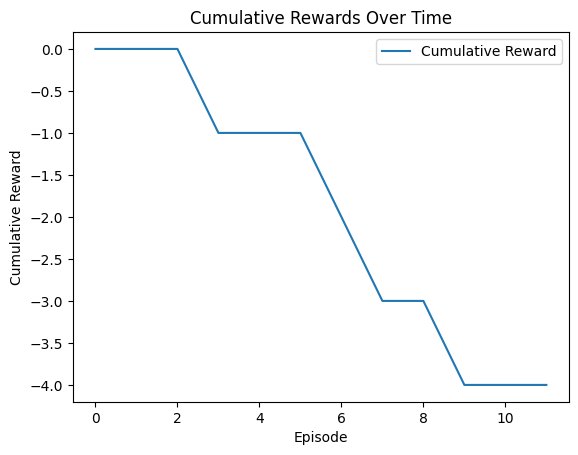

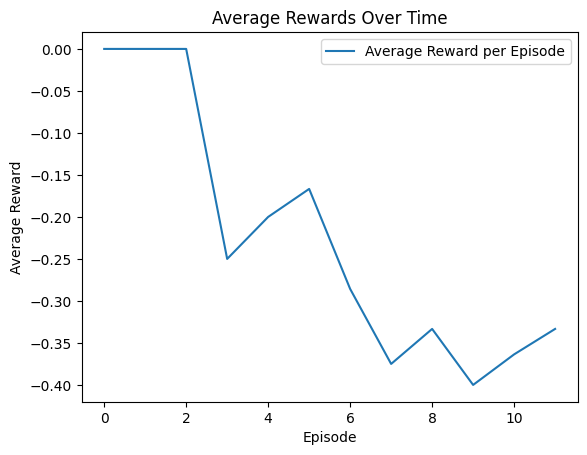

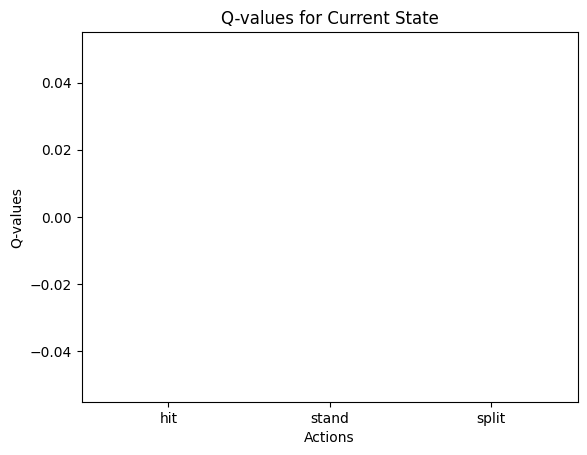

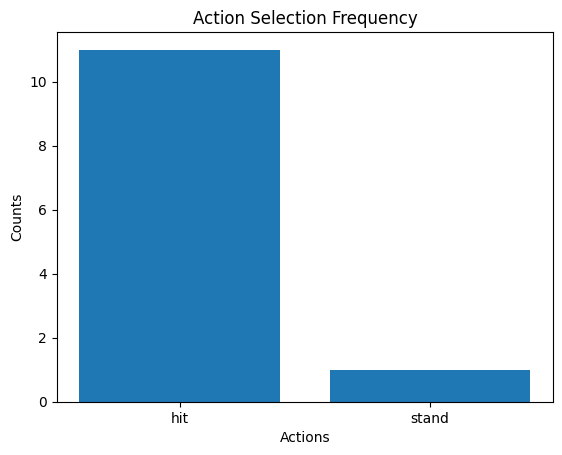

In [10]:
# Initialize environment and agent
env = BlackjackEnvironment(cnn_model=model, n_decks=8)
actions = ['hit', 'stand', 'split']
agent = QLearningAgent(state_space=None, action_space=actions)

# Create and start the GUI
root = tk.Tk()
app = BlackjackRL(
    root=root, 
    agent=agent, 
    environment=env, 
    train_episodes=1000,
    test_episodes=100,
    cnn_model_path='./models/5_model.h5', 
    rl_model_path='./models/q_learning_model.pkl'
)

app.start()

# Now to use Deep Q Learning (DQN) in order to get the reinforcement learning model to take the probabilities of the card counter into account

In [13]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    def __init__(self, state_size, action_space, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.001, batch_size=32):
        self.state_size = state_size
        self.action_size = len(action_space)
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = DQN(state_size, self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.rewards = []

    def remember(self, state, action, reward, next_state, done):
        action_idx = self.action_space.index(action)
        self.memory.append((state, action_idx, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            available_actions = self.action_space if state[-1] else [a for a in self.action_space if a != 'split']
            return random.choice(available_actions)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        if not state[-1]:
            act_values[self.action_space.index('split')] = -float('inf')
        action_idx = torch.argmax(act_values).item()
        return self.action_space[action_idx]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action_idx, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state)
                target += self.gamma * torch.max(self.model(next_state)).item()
            state = torch.FloatTensor(state)
            target_f = self.model(state).detach()
            target_f[action_idx] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load_model(self, name):
        self.model.load_state_dict(torch.load(name))

    def save_model(self, name):
        torch.save(self.model.state_dict(), name)


class DQNBlackjackEnvironment:
    def __init__(self, cnn_model, n_decks):
        self.player_hand = []
        self.dealer_hand = []
        self.split_hands = []
        self.player_hand_real = []
        self.dealer_hand_real = []
        self.split_hands_real = []
        self.active_hand = 0
        self.wins = 0
        self.losses = 0
        self.draws = 0
        self.card_counter = CardCounter(model=cnn_model, n_decks=n_decks)
        self.deck = self.create_deck()
        self.probabilities = {}

    def create_deck(self):
        ranks = ('two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace')
        suits = ('hearts', 'diamonds', 'clubs', 'spades')
        deck = [(rank, suit) for rank in ranks for suit in suits] * self.card_counter.n_decks
        random.shuffle(deck)
        return deck

    def deal_card(self):
        if not self.deck:
            self.deck = self.create_deck()

        card = self.deck.pop()
        self.card_counter.total_cards -= 1
        if self.card_counter.total_cards == 0:
            self.reset_deck()

        return card

    def calculate_hand_value(self, hand):
        ranks = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
                 'jack': 10, 'queen': 10, 'king': 10, 'ace': 11}
        value = 0
        ace_count = 0
        for card in hand:
            rank = card[0]
            value += ranks[rank]
            if rank == 'ace':
                ace_count += 1

        while value > 21 and ace_count:
            value -= 10
            ace_count -= 1

        return value

    def reset(self):
        self.player_hand = [self.deal_card()]
        self.dealer_hand = [self.deal_card()]
        self.player_hand.append(self.deal_card())
        self.dealer_hand.append(self.deal_card())
        self.player_hand_real = self.player_hand.copy()
        self.dealer_hand_real = self.dealer_hand.copy()
        self.split_hands = []
        self.split_hands_real = []
        self.active_hand = 0
        return self.get_state()

    def reset_deck(self):
        self.deck = self.create_deck()
        self.card_counter.reset_deck()

    def one_hot_encode_rank(self, rank):
        ranks = ['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'ace']
        encoding = [0] * len(ranks)
        encoding[ranks.index(rank)] = 1
        return encoding

    def get_state(self):
        player_hand_value = self.calculate_hand_value(self.get_active_hand())
        dealer_visible_card = self.one_hot_encode_rank(self.dealer_hand_real[0][0])
        usable_ace = 1 if self.usable_ace(self.get_active_hand()) else 0
        prob_low, prob_high, prob_neutral = self.calculate_probabilities()
        return [player_hand_value] + dealer_visible_card + [usable_ace] + [prob_low, prob_high, prob_neutral, self.can_split()]

    def calculate_probabilities(self):
        if len(self.probabilities.keys()) > 0:
            probabilities = self.probabilities[len(self.probabilities) - 1]
            prob_high = probabilities['high']
            prob_low = probabilities['low']
            prob_neutral = probabilities['neutral']
        else:
            prob_high = 5 / 13
            prob_low = 5 / 13
            prob_neutral = 3 / 13

        return prob_high, prob_low, prob_neutral

    def usable_ace(self, hand):
        return 1 in [card[0] == 'ace' for card in hand] and self.calculate_hand_value(hand) + 10 <= 21

    def step(self, action):
        if action == 'hit':
            if self.active_hand == 0:
                self.player_hand.append(self.deal_card())
                self.player_hand_real.append(self.player_hand[-1])
                real_hand_value = self.calculate_hand_value(self.player_hand_real)
                if real_hand_value > 21:
                    self.losses += 1
                    return self.get_state(), -1, False  # Player busts
                elif real_hand_value == 21:
                    self.wins += 1
                    return self.get_state(), 1.5, False  # Blackjack
                else:
                    return self.get_state(), 0, False  # Continue game
            else:
                self.split_hands[self.active_hand - 1].append(self.deal_card())
                self.split_hands_real[self.active_hand - 1].append(self.split_hands[self.active_hand - 1][-1])
                real_split_value = self.calculate_hand_value(self.split_hands_real[self.active_hand - 1])
                if real_split_value >= 21:
                    self.active_hand += 1
                    if self.active_hand > len(self.split_hands):
                        return self.step('stand')

                    if real_split_value > 21:
                        return self.get_state(), -1, False
                    elif real_split_value == 21:
                        return self.get_state(), 1.5, False
                    else:
                        return self.get_state(), 0, False

                return self.get_state(), 0, False

        elif action == 'stand':
            if self.active_hand == 0 and self.split_hands:
                self.active_hand += 1
                return self.get_state(), 0, False
            elif self.active_hand <= len(self.split_hands):
                self.active_hand += 1
                if self.active_hand <= len(self.split_hands):
                    return self.get_state(), 0, False

            while self.calculate_hand_value(self.dealer_hand_real) < 17:
                self.dealer_hand.append(self.deal_card())
                self.dealer_hand_real.append(self.dealer_hand[-1])

            dealer_value = self.calculate_hand_value(self.dealer_hand_real)
            player_value = self.calculate_hand_value(self.player_hand_real)
            split_values = [self.calculate_hand_value(hand) for hand in self.split_hands]

            rewards = []

            if player_value == 21:
                rewards.append(1.5)
            elif player_value < 21:
                if dealer_value > 21 or player_value > dealer_value:
                    rewards.append(1)
                    self.wins += 1
                elif player_value < dealer_value:
                    rewards.append(-1)
                    self.losses += 1
                elif dealer_value == player_value:
                    rewards.append(0)
                    self.draws += 1
            else:
                rewards.append(-1)
                self.losses += 1

            for split_value in split_values:
                if split_value == 21:
                    rewards.append(1.5)
                elif split_value < 21:
                    if dealer_value > 21 or split_value > dealer_value:
                        rewards.append(1)
                        self.wins += 1
                    elif split_value < dealer_value:
                        rewards.append(-1)
                        self.losses += 1
                    elif dealer_value == split_value:
                        rewards.append(0)
                        self.draws += 1
                else:
                    rewards.append(-1)
                    self.losses += 1

            return self.get_state(), sum(rewards), True

        elif action == 'split' and len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
            new_hand = [self.player_hand.pop()]
            self.split_hands.append(new_hand)
            self.split_hands_real.append(new_hand.copy())
            self.player_hand.append(self.deal_card())
            self.split_hands[-1].append(self.deal_card())
            self.split_hands_real[-1].append(self.split_hands[-1][-1])
            return self.get_state(), 0, False

        return self.get_state(), 0, False  # Invalid action or game continues

    def get_active_hand(self):
        if self.active_hand == 0:
            return self.player_hand
        else:
            return self.split_hands[self.active_hand - 1] if len(self.split_hands) >= self.active_hand else []

    def move_to_next_hand(self):
        if self.active_hand < len(self.split_hands):
            self.active_hand += 1
            return True
        return False

    def can_split(self):
        return len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]


class DQNBlackjackRL:
    def __init__(self, root, agent, environment, train_episodes, test_episodes, cnn_model_path, rl_model_path):
        self.root = root
        self.agent = agent
        self.environment = environment
        self.train_episodes = train_episodes
        self.test_episodes = test_episodes
        self.card_images = []
        self.root.title("Blackjack RL Agent")

        # Load the trained model
        self.cnn_model_path = cnn_model_path
        self.rl_model_path = rl_model_path
        self.cnn_model = self.load_cnn_model()
        self.card_counter = CardCounter(model=self.cnn_model, n_decks=environment.card_counter.n_decks)

        # Create frames
        self.game_frame = tk.Frame(self.root)
        self.game_frame.pack(side=tk.LEFT, padx=10, pady=10)
        self.stats_frame = tk.Frame(self.root)
        self.stats_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        # Create game widgets
        self.player_label = tk.Label(self.game_frame, text="Player's Hand")
        self.player_label.grid(row=0, column=0, columnspan=4)
        self.player_frame = tk.Frame(self.game_frame)
        self.player_frame.grid(row=1, column=0, columnspan=4)

        self.split_frames = [tk.Frame(self.game_frame) for _ in range(3)]  # Initialize split frames

        self.dealer_label = tk.Label(self.game_frame, text="Dealer's Hand")
        self.dealer_label.grid(row=2, column=0, columnspan=4, pady=(20, 0))
        self.dealer_frame = tk.Frame(self.game_frame)
        self.dealer_frame.grid(row=3, column=0, columnspan=4)

        self.status_label = tk.Label(self.game_frame, text="")
        self.status_label.grid(row=4, column=0, columnspan=4)

        self.save_button = tk.Button(self.game_frame, text="Save Model", command=self.save_rl_model)
        self.save_button.grid(row=5, column=0)
        self.load_button = tk.Button(self.game_frame, text="Load Model", command=self.load_rl_model)
        self.load_button.grid(row=5, column=1)

        self.hit_button = tk.Button(self.game_frame, text="Hit", command=self.hit)
        self.hit_button.grid(row=5, column=2)
        self.stand_button = tk.Button(self.game_frame, text="Stand", command=self.stand)
        self.stand_button.grid(row=5, column=3)
        self.split_button = tk.Button(self.game_frame, text="Split", command=self.split)
        self.split_button.grid(row=6, column=0, columnspan=4)

        # Create stats widgets
        self.cumulative_rewards_fig, self.cumulative_rewards_ax = plt.subplots()
        self.cumulative_rewards_canvas = FigureCanvasTkAgg(self.cumulative_rewards_fig, master=self.stats_frame)
        self.cumulative_rewards_canvas.get_tk_widget().grid(row=0, column=0)

        self.average_rewards_fig, self.average_rewards_ax = plt.subplots()
        self.average_rewards_canvas = FigureCanvasTkAgg(self.average_rewards_fig, master=self.stats_frame)
        self.average_rewards_canvas.get_tk_widget().grid(row=0, column=1)

        self.q_values_fig, self.q_values_ax = plt.subplots()
        self.q_values_canvas = FigureCanvasTkAgg(self.q_values_fig, master=self.stats_frame)
        self.q_values_canvas.get_tk_widget().grid(row=1, column=0)

        self.action_counts_fig, self.action_counts_ax = plt.subplots()
        self.action_counts_canvas = FigureCanvasTkAgg(self.action_counts_fig, master=self.stats_frame)
        self.action_counts_canvas.get_tk_widget().grid(row=1, column=1)

        self.win_loss_label = tk.Label(self.stats_frame, text="Wins: 0, Losses: 0, Draws: 0")
        self.win_loss_label.grid(row=5, column=0, columnspan=2)

        self.prob_label = tk.Label(self.stats_frame, text="Probabilities - High: 0.00, Low: 0.00, Neutral: 0.00")
        self.prob_label.grid(row=5, column=1, columnspan=2)

        self.test_button = tk.Button(self.game_frame, text="Test Agent",
                                     command=lambda: self.test_agent(games=test_episodes))
        self.test_button.grid(row=7, column=0, columnspan=4)

        self.episode_count = 0
        self.train_agent()

    def load_cnn_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(53, activation='softmax')  # 53 classes for 53 cards
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.load_weights(self.cnn_model_path)  # Load your trained model weights
        return model

    def save_rl_model(self):
        self.agent.save_model(self.rl_model_path)
        messagebox.showinfo("Model Saved", "The Q-learning model has been saved successfully.")

    def load_rl_model(self):
        self.agent.load_model(self.rl_model_path)
        messagebox.showinfo("Model Loaded", "The Q-learning model has been loaded successfully.")

    def update_stats(self):
        cumulative_rewards = np.cumsum(self.agent.rewards)
        self.cumulative_rewards_ax.clear()
        self.cumulative_rewards_ax.plot(cumulative_rewards, label='Cumulative Reward')
        self.cumulative_rewards_ax.set_xlabel('Episode')
        self.cumulative_rewards_ax.set_ylabel('Cumulative Reward')
        self.cumulative_rewards_ax.set_title('Cumulative Rewards Over Time')
        self.cumulative_rewards_ax.legend()
        self.cumulative_rewards_canvas.draw()

        if len(self.agent.rewards) > 0:
            average_rewards = cumulative_rewards / (np.arange(len(self.agent.rewards)) + 1)
            self.average_rewards_ax.clear()
            self.average_rewards_ax.plot(average_rewards, label='Average Reward per Episode')
            self.average_rewards_ax.set_xlabel('Episode')
            self.average_rewards_ax.set_ylabel('Average Reward')
            self.average_rewards_ax.set_title('Average Rewards Over Time')
            self.average_rewards_ax.legend()
            self.average_rewards_canvas.draw()
        else:
            print("No rewards to plot for average rewards")

        state = self.environment.get_state()
        q_values = self.agent.model(torch.FloatTensor(state)).detach().numpy()
        self.q_values_ax.clear()
        self.q_values_ax.bar(self.agent.action_space, q_values)
        self.q_values_ax.set_xlabel('Actions')
        self.q_values_ax.set_ylabel('Q-values')
        self.q_values_ax.set_title('Q-values for Current State')
        self.q_values_canvas.draw()

        action_counts = {action: sum(
            [1 for _, action_idx, _, _, _ in self.agent.memory if self.agent.action_space[action_idx] == action]) for
                         action in self.agent.action_space}
        actions = list(action_counts.keys())
        counts = list(action_counts.values())
        self.action_counts_ax.clear()
        self.action_counts_ax.bar(actions, counts)
        self.action_counts_ax.set_xlabel('Actions')
        self.action_counts_ax.set_ylabel('Counts')
        self.action_counts_ax.set_title('Action Selection Frequency')
        self.action_counts_canvas.draw()

        self.win_loss_label.config(
            text=f"Wins: {self.environment.wins}, Losses: {self.environment.losses}, Draws: {self.environment.draws}")

    def display_hand(self, hand, frame, is_real=True):
        for widget in frame.winfo_children():
            widget.destroy()

        predicted_hand = []
        for i, card in enumerate(hand):
            img_path = f'./data/test/{card[0]} of {card[1]}/1.jpg'

            if not os.path.exists(img_path):
                print(f"Image path does not exist: {img_path}")
                continue

            images = [tf.image.decode_jpeg(tf.io.read_file(img_path), channels=3)]
            prob_high, prob_low, prob_neutral, predicted_cards = self.card_counter.count_cards(images=images)
            self.prob_label.config(text=f'Probabilities - High: {prob_high:.2f}, Low: {prob_low:.2f}, Neutral: {prob_neutral:.2f}')

            self.environment.probabilities[len(self.environment.probabilities.keys())] = {
                'high': prob_high,
                'low': prob_low,
                'neutral': prob_neutral
            }

            predicted_card = predicted_cards[0]
            predicted_img_path = f'./data/test/{predicted_card[0]} of {predicted_card[1]}/1.jpg'

            if not os.path.exists(predicted_img_path):
                print(f"Image path does not exist: {predicted_img_path}")
                return

            predicted_hand.append(predicted_card)

            try:
                img = Image.open(img_path)
                img = img.resize((100, 150), Image.LANCZOS)
                photo = ImageTk.PhotoImage(img)
                self.card_images.append(photo)
                label = tk.Label(frame, image=photo)
                label.image = photo
                label.grid(row=0, column=i)
                tk.Label(frame,
                         text=f'Actual: {card[0]} of {card[1]}\nPredicted: {predicted_card[0]} of {predicted_card[1]}').grid(
                    row=1, column=i)
            except Exception as e:
                print(f"Failed to load image {img_path}: {e}")

        if not is_real:
            return predicted_hand

        return hand

    def deal_card_to_player(self):
        card = self.environment.deal_card()
        self.environment.get_active_hand().append(card)
        predicted_cards = self.display_hand(self.environment.get_active_hand(), self.player_frame, is_real=False)
        if self.environment.active_hand == 0:
            self.environment.player_hand = predicted_cards
        else:
            self.environment.split_hands[self.environment.active_hand - 1] = predicted_cards

    def deal_card_to_dealer(self):
        card = self.environment.deal_card()
        self.environment.dealer_hand.append(card)
        predicted_cards = self.display_hand(self.environment.dealer_hand, self.dealer_frame, is_real=False)
        self.environment.dealer_hand = predicted_cards

    def hit(self):
        self.deal_card_to_player()
        if self.environment.calculate_hand_value(self.environment.get_active_hand()) > 21:
            self.status_label.config(text="Player busts! Dealer wins!")
            self.environment.losses += 1
            self.agent.rewards.append(-1)
            self.root.after(1000, self.train_agent)

    def stand(self):
        if self.environment.move_to_next_hand():
            return
        while self.environment.calculate_hand_value(self.environment.dealer_hand_real) < 17:
            self.deal_card_to_dealer()

        dealer_value = self.environment.calculate_hand_value(self.environment.dealer_hand_real)
        player_value = self.environment.calculate_hand_value(self.environment.player_hand_real)
        split_values = [self.environment.calculate_hand_value(hand) for hand in self.environment.split_hands]

        if dealer_value > 21 or player_value > dealer_value or any(
                split_value > dealer_value for split_value in split_values):
            self.status_label.config(text="Player wins!")
            self.environment.wins += 1
            self.agent.rewards.append(1)
        elif player_value < dealer_value and all(split_value < dealer_value for split_value in split_values):
            self.status_label.config(text="Dealer wins!")
            self.environment.losses += 1
            self.agent.rewards.append(-1)
        else:
            self.status_label.config(text="Draw!")
            self.environment.draws += 1
            self.agent.rewards.append(0)

        self.update_stats()
        self.root.after(1000, self.train_agent)

    def split(self):
        if self.environment.can_split():
            new_hand = [self.environment.player_hand.pop()]
            self.environment.split_hands.append(new_hand)
            self.environment.split_hands_real.append(new_hand.copy())
            self.environment.player_hand.append(self.environment.deal_card())
            self.environment.split_hands[-1].append(self.environment.deal_card())
            self.environment.split_hands_real[-1].append(self.environment.split_hands[-1][-1])
            return self.environment.get_state(), 0, False

    def reset_game(self):
        self.environment.reset()
        self.display_hand(self.environment.player_hand, self.player_frame)
        self.display_hand(self.environment.dealer_hand, self.dealer_frame)
        self.environment.split_hands = []
        self.environment.active_hand = 0
        for split_frame in self.split_frames:
            split_frame.grid_forget()
        self.status_label.config(text="")

    def train_agent(self):
        self.reset_game()
        state = self.environment.get_state()
        done = False

        while not done:
            self.root.update_idletasks()
            self.root.update()
            action = self.agent.act(state)
            next_state, reward, done = self.environment.step(action)
            self.agent.remember(state, action, reward, next_state, done)
            self.agent.replay()
            state = next_state
            if done:
                self.episode_count += 1
                self.agent.rewards.append(reward)
                self.update_stats()
                self.root.after(1000, self.train_agent)
                break
            self.root.after(1000, lambda: None)

    def test_agent(self, games=100):
        wins, losses, draws = 0, 0, 0
        for _ in range(games):
            state = self.environment.reset()
            done = False
            while not done:
                action = self.agent.act(state)
                next_state, reward, done = self.environment.step(action)
                state = next_state
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1
        messagebox.showinfo("Test Results",
                            f"Results over {games} games:\nWins: {wins}\nLosses: {losses}\nDraws: {draws}")

    def start(self):
        self.root.mainloop()

Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
1/1 [==============================] - 0s 31ms/step


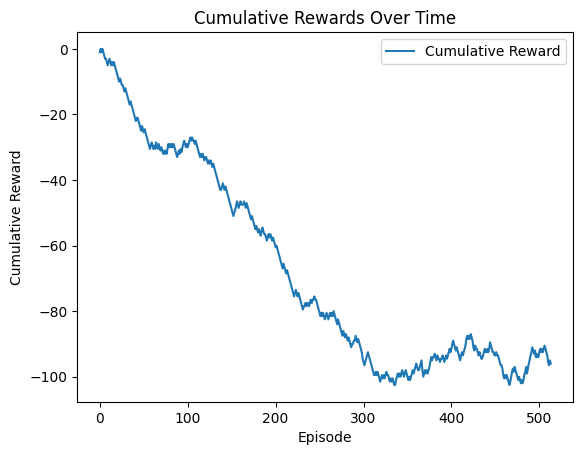

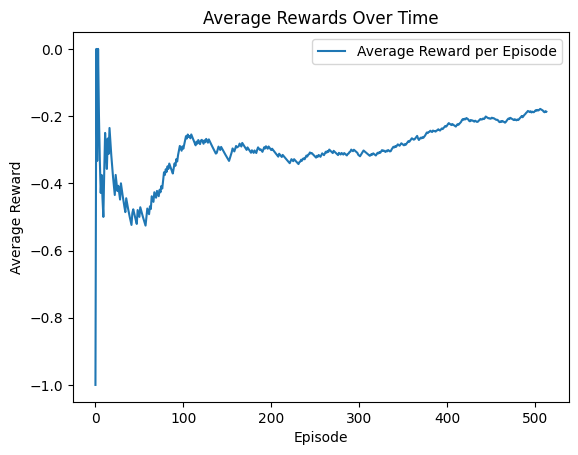

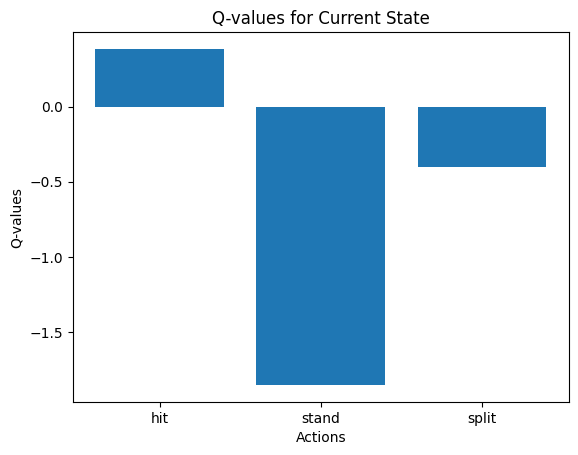

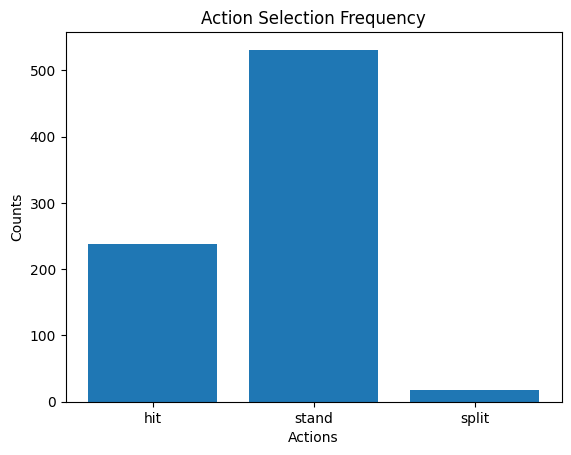

In [14]:
# Calculate the state size based on the returned state from get_state method
player_hand_value_size = 1
dealer_visible_card_size = 13  # One-hot encoding of 13 ranks
usable_ace_size = 1
probabilities_size = 3
split_possibility_indicatory = 1

state_size = player_hand_value_size + dealer_visible_card_size + usable_ace_size + probabilities_size + split_possibility_indicatory
actions = ['hit', 'stand', 'split']

env = DQNBlackjackEnvironment(cnn_model=model, n_decks=8)
agent = DQNAgent(state_size=state_size, action_space=actions)

# Create and start the GUI
root = tk.Tk()
app = DQNBlackjackRL(
    root=root, 
    agent=agent, 
    environment=env, 
    train_episodes=1000,
    test_episodes=100,
    cnn_model_path='./models/5_model.h5', 
    rl_model_path='./models/dqn_model.pkl'
)

app.start()

# Must update environment and gui classes because they seem to both be adding the rewards and checking for wins and losses.
# Must ensure that q values for split are zero when cards can't be split